In [39]:
from src import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
body { font-size: 20px; }
""")

<h1><center>Integrate-and-fire time encoding</center></h1>

In this notebook, we investigate systems that sample signals using the integrate-and-fire time encoding machine (TEM) model as depicted in the circuit below:
<img src="notebook figures/TEM_circuit.png" width=400 height=400 />

We look into:
1. the encoding of signals using such a TEM,
1. the recovery of one signal from its time encoding using such a TEM
1. the recovery of one signal from its time encoding using multiple such TEMs
1. the recovery of many signals from their time encoding using multiple channels, with known and unknown mixing, and
1. the recovery of weights of of spiking neural networks with one or two layers, such that these weights are consistent with examples provided by a teacher network

## 0. Signal Creation
First let us create a bandlimited signal with bandwidth $\pi$ and sample it at times t

Text(0.5, 1.0, 'Input Signal to be time encoded')

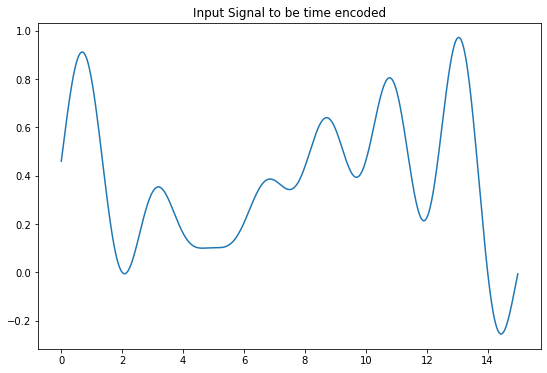

In [38]:
# parameters for signal creation
np.random.seed(1)
Omega = np.pi
signal_end_time = 15
delta_t = 1e-2
t = np.arange(0,signal_end_time,delta_t)

# creation of bandlimited signal
y_param = Signal.bandlimitedSignal(np.pi)
y_param.random(t) # generates a random bandlimited signal
y_sampled = y_param.sample(t) # sample the signal at time t

# create a collection of bandlimited signals containing y_param
y_param_as_collection = Signal.bandlimitedSignals(np.pi)
y_param_as_collection.add(y_param)

plt.figure(figsize = (9,6))
plt.plot(t, y_sampled, label = 'input signal')
plt.title("Input Signal to be time encoded")

## 1. Signal Time Encoding

Integrate-and-fire time encoding can be performed either using discretisations (i.e. approximation the signal's integral with a sum) or in a continuous way by searching for the next spike time using binary search assuming a parametric model of a signal.

Text(0.5, 1.0, 'Sampled signal and spikes')

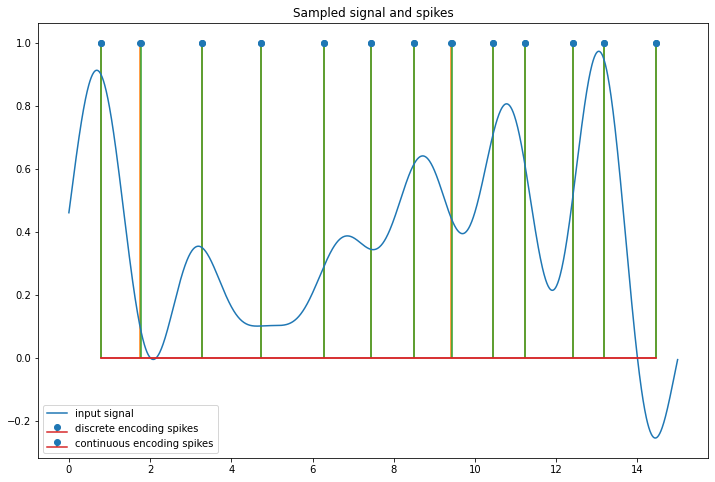

In [40]:
# creation of an object which holds the parameters of the TEM
tem_parameters = TEMParams(kappa = 1, delta = 0.5, b = 0.5, mixing_matrix = [[1]])

# creation of the discrete encoder and encoding of input signal
discrete_encoder = Encoder.DiscreteEncoder(tem_parameters)
discrete_encoding_spikes = discrete_encoder.encode(y_sampled, signal_end_time, delta_t)

# creation of the continuous encoder and encoding of input signal
continuous_encoder = Encoder.ContinuousEncoder(tem_parameters)
continuous_encoding_spikes = continuous_encoder.encode(y_param_as_collection, signal_end_time)

# Plotting spikes versus signal
plt.figure(figsize = (9,6))
plt.plot(t, y_sampled, label = 'input signal')
plt.stem(discrete_encoding_spikes[0], np.ones_like(discrete_encoding_spikes[0]), use_line_collection = True, linefmt = 'C1-', label = 'discrete encoding spikes')
plt.legend(loc = 'best')
plt.stem(continuous_encoding_spikes[0], np.ones_like(continuous_encoding_spikes[0]), use_line_collection = True, linefmt = 'C2-', label = 'continuous encoding spikes')
plt.legend(loc = 'best')
plt.title('Sampled signal and spikes')


## 2. Signal Recovery from One-Channel Time Encoding

We can decode the incoming input signal from the spikes, let us use the continuously computed spikes to do this. 
The quality of the reconstruction will depend on the number of spikes available to perform the reconstruction.

Text(0.5, 1.0, 'Signal recovery from an insufficient number of spikes')

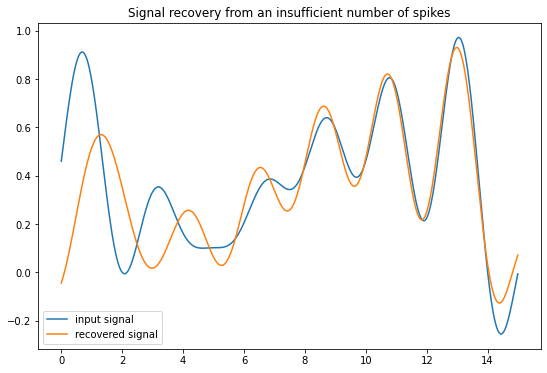

In [42]:
# we create the decoder using the time encoding machine parameters defined earlier
decoder = Decoder.SSignalMChannelDecoder(tem_parameters, periodic = False, Omega = np.pi)
y_recovered = decoder.decode(continuous_encoding_spikes, t)

# we plot the recovered signal versus the original signal
plt.figure(figsize = (9,6))
plt.plot(t, y_sampled, label = 'input signal')
plt.plot(t, y_recovered, label = "recovered signal")
plt.legend(loc = 'best')
plt.title('Signal recovery from an insufficient number of spikes')

We do not have enough spikes to ensure a good enough recovery. To increase the number of available spikes, we can decrease the threshold $\delta$ of the time encoding machine.

Text(0.5, 1.0, 'Signal recovery from a sufficient number of spikes')

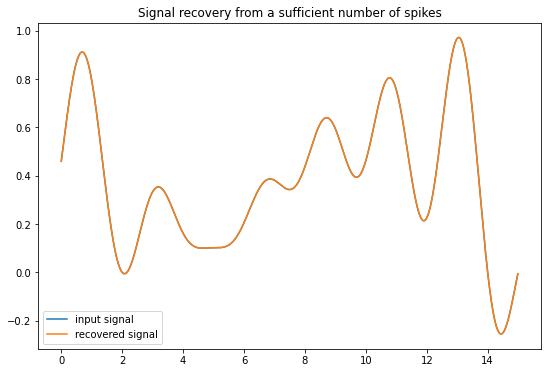

In [48]:
# we update the parameters of the TEM
tem_parameters.delta = 0.25
# note that both the decoder and encoder act according to the tem_parameters object referenced above

# we encode and decode the signal again
continuous_encoding_spikes = continuous_encoder.encode(y_param_as_collection, signal_end_time)
y_recovered = decoder.decode(continuous_encoding_spikes, t)

# Plotting recovered signal versus original signal
plt.figure(figsize = (9,6))
plt.plot(t, y_sampled, label = 'input signal')
plt.plot(t, y_recovered, label = "recovered signal")
plt.legend(loc = 'best')
plt.title('Signal recovery from a sufficient number of spikes')

## 3. Signal Recovery from Multi-Channel Time Encoding
In cases where the parameters of a TEM are fixed and its spiking output does not suffice to ensure recovery of a signal, one can compensate for that by using multiple time encoding machines to encode a signal

Text(0.5, 1.0, 'Signal recovery from the spikes of two TEMs')

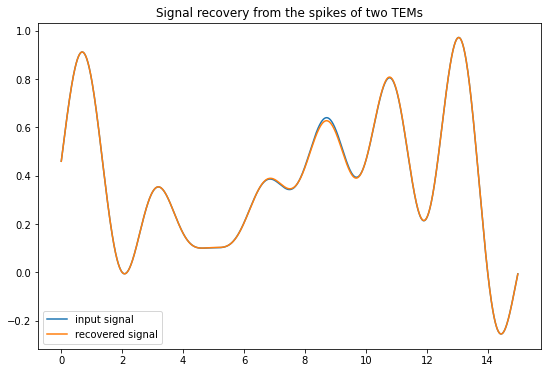

In [51]:
# we create a two channel time encoding machine and use it to encode the input signal
n_channels = 2
tem_parameters_double = TEMParams(kappa = 1, delta = 0.5, b = 0.5, mixing_matrix = [[1],[1]], integrator_init =[0,-0.5])
continuous_encoder_double = Encoder.ContinuousEncoder(tem_parameters_double)
two_channel_encoding_spikes = continuous_encoder_double.encode(y_param_as_collection, signal_end_time)

# we recover the input signal from the output spikes
decoder = Decoder.SSignalMChannelDecoder(tem_parameters_double, periodic = False, Omega = np.pi)
y_recovered = decoder.decode(two_channel_encoding_spikes, t)

# Plotting recovered signal versus original signal
plt.figure(figsize = (9,6))
plt.plot(t, y_sampled, label = 'input signal')
plt.plot(t, y_recovered, label = "recovered signal")
plt.legend(loc = 'best')
plt.title('Signal recovery from the spikes of two TEMs')

## 4. Multi-Signal Recovery from Multi-Channel Time Encoding

Now we consider the case where 2 signals are encoded using a 100-channel time encoding machine.

### Known Mixing
In the case where the transformation between the inputs to the system and the inputs to the channels is known, the recovery algorithm uses this known transformation as a constraint during the recovery.

Text(0.5, 1.0, 'Input signals and corresponding recovered signals')

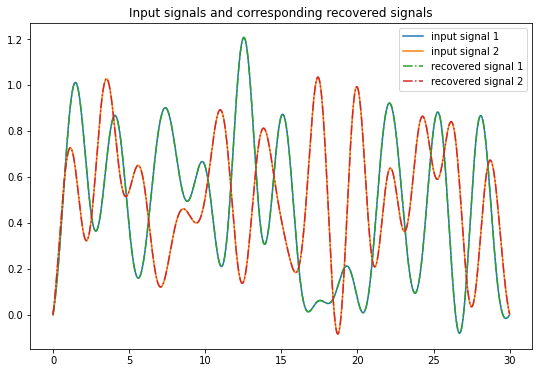

In [56]:
# we create a TEM that encodes 2 signals using 100 channels
np.random.seed(10)
kappa, delta, b = 1, 1, 0.5
n_signals = 2
n_channels = 100
mixing_matrix = np.random.random((n_channels,n_signals))
tem_parameters_multi = TEMParams(kappa, delta, b, mixing_matrix = mixing_matrix)
continuous_encoder_multi = Encoder.ContinuousEncoder(tem_parameters_multi)

# we create the collection of 2 signals that are fed in as input
signal_end_time = 30
Omega = np.pi
period = np.pi/Omega
sinc_locs = np.arange(period,signal_end_time,period)
sinc_amps = np.random.random((n_signals, len(sinc_locs)))
y_param = Signal.bandlimitedSignals(np.pi, sinc_locs , sinc_amps)

# we encode the signals
multi_channel_encoding_spikes = continuous_encoder_multi.encode(y_param, signal_end_time)

# we recover each of the 2 signals
t = np.arange(0, signal_end_time, 1e-2)
decoder = Decoder.MSignalMChannelDecoder(tem_parameters_multi, periodic = False, Omega = np.pi, sinc_locs = sinc_locs)
y_recovered = decoder.decode(multi_channel_encoding_spikes, t)

# we plot the recovered signal versus the original signal
plt.figure(figsize = (9,6))
plt.plot(t, y_param.sample(t).T[:,0], label = 'input signal 1')
plt.plot(t, y_param.sample(t).T[:,1], label = 'input signal 2')
plt.plot(t, y_recovered.T[:,0], linestyle = '-.', label = "recovered signal 1")
plt.plot(t, y_recovered.T[:,1], linestyle = '-.', label = "recovered signal 2")
plt.legend(loc = 'best')
plt.title("Input signals and corresponding recovered signals")

### No Mixing
Note that the quality of the reconstruction above critically relies on the knowledge of the transformation between input signals and channels. In fact, if we assume the transformation doesn't exist (i.e. all the channels have to recover their inputs separately rather than collaboratively), we notice a serious degradation in the quality of recovery.

Text(0.5, 1.0, 'Channel input signals and corresponding recovered signals')

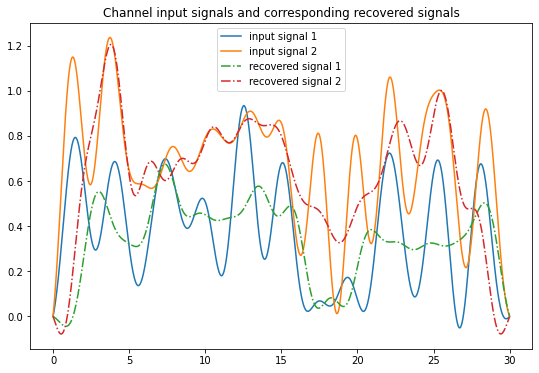

In [57]:
# we now pretend that there are 100 input signals fed into 100 TEMs, separately
tem_parameters_multi = TEMParams(kappa, delta, b, mixing_matrix = np.eye(n_channels))
continuous_encoder_multi = Encoder.ContinuousEncoder(tem_parameters_multi)

# we create the collection of signals input to each channel which in reality are linear combinations
# of two signals (the information of which is present in sinc_amps)
y_param = Signal.bandlimitedSignals(np.pi, sinc_locs , mixing_matrix.dot(sinc_amps))

# we encode the inputs to the channels
multi_channel_encoding_spikes = continuous_encoder_multi.encode(y_param, signal_end_time)

# and recover these inputs
decoder = Decoder.MSignalMChannelDecoder(tem_parameters_multi, periodic = False, Omega = np.pi, sinc_locs = sinc_locs)
y_recovered = decoder.decode(multi_channel_encoding_spikes, t)

# Plotting recovered signal versus original signal
plt.figure(figsize = (9,6))
plt.plot(t, y_param.sample(t).T[:,0], label = 'input signal 1')
plt.plot(t, y_param.sample(t).T[:,1], label = 'input signal 2')
plt.plot(t, y_recovered.T[:,0], linestyle = '-.', label = "recovered signal 1")
plt.plot(t, y_recovered.T[:,1], linestyle = '-.', label = "recovered signal 2")
plt.legend(loc = 'best')
plt.title("Channel input signals and corresponding recovered signals")

### Unknown Mixing
In the case where the transformation from inputs to channels is not known but we know that it exists and we know the true dimensionality of the input signals (i.e. how many signals are mixed using linear combinations to form the inputs to the channels), we can perform better than in the case where we assume all signals are independent

exited at iteration  5488


Text(0.5, 1.0, 'Channel input signals and corresponding recovered signals')

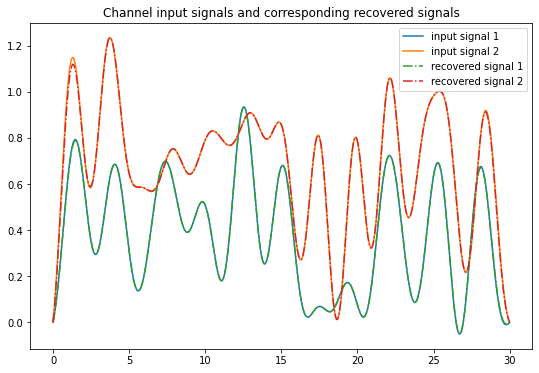

In [58]:
decoder = Decoder.UnknownMixingDecoder(tem_parameters_multi, periodic = False, Omega = np.pi, sinc_locs = sinc_locs)
y_recovered = decoder.decode(multi_channel_encoding_spikes, 3, t)

# Plotting recovered signal versus original signal
plt.figure(figsize = (9,6))
plt.plot(t, y_param.sample(t).T[:,0], label = 'input signal 1')
plt.plot(t, y_param.sample(t).T[:,1], label = 'input signal 2')
plt.plot(t, y_recovered.T[:,0], linestyle = '-.', label = "recovered signal 1")
plt.plot(t, y_recovered.T[:,1], linestyle = '-.', label = "recovered signal 2")
plt.legend(loc = 'best')
plt.title("Channel input signals and corresponding recovered signals")

## 5. Recovery of Weights of a Spiking Neural Network


### Single Layer Case
We recover the weights of a spiking neural network with one layer with 20 inputs and 5 outputs by showing it examples that it should mimick and deriving constraints on the weights of the network from these examples.

Here, we use 4 examples to perform the recovery and take a look at the error on the weight matrix we obtain after learning

(5, 20)


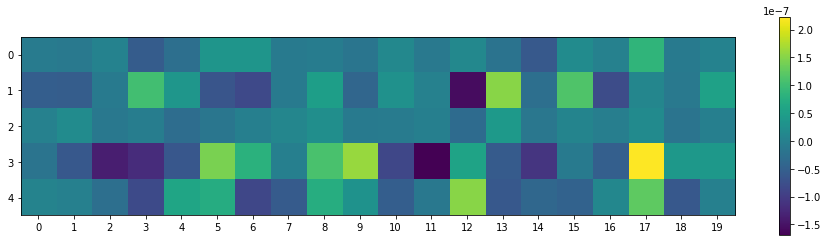

In [60]:
n_inputs = 20
n_outputs = 5
n_examples = 4
A = np.random.random(size=(n_outputs, n_inputs))
period = 10
sampling_time = 10

signals = []
spikes_mult = []
tem_params = TEMParams(1, 1, 1, A)

np.random.seed(10)
for n_e in range(n_examples):
    signals.append(Signal.periodicBandlimitedSignals(period))
    for n_i in range(n_inputs):
        signals[-1].add(Signal.periodicBandlimitedSignal(10, 10, np.random.random(size=(10,))))
    spikes = Encoder.ContinuousEncoder(tem_params).encode(signals[-1], sampling_time)
    spikes_mult.append(spikes)


single_layer = Layer(n_inputs, n_outputs)
single_layer.learn_weight_matrix_from_m_ex(signals, spikes_mult)

plt.figure(figsize =(16,4))
hm = plt.imshow(A-np.real(single_layer.weight_matrix))
plt.colorbar(hm)
ax = plt.gca()
ax.set_xticks(np.arange(0,n_inputs))
ax.set_yticks(np.arange(0, n_outputs))